# Tensorboardの使い方

- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [182]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

In [183]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])

In [184]:
trainset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=True,
    transform=transform)

testset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=False,
    transform=transform)

In [185]:
x, y = trainset[0]

In [186]:
print(x.min(), x.max())
print(y)

tensor(-1.) tensor(1.)
9


In [187]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [188]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [189]:
x.shape

torch.Size([1, 28, 28])

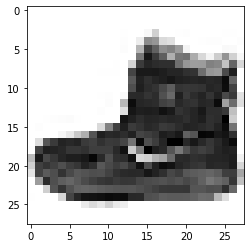

In [190]:
matplotlib_imshow(x, one_channel=True)

In [191]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

In [192]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [193]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [194]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

## 画像の書き込み

In [195]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')
print(writer.log_dir)

runs/fashion_mnist_experiment_1


In [196]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

images.shape, labels.shape

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

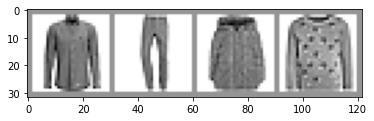

In [197]:
img_grid = torchvision.utils.make_grid(images, nrow=6)
matplotlib_imshow(img_grid, one_channel=True)

In [198]:
writer.add_image('four_fashion_mnist_images', img_grid)

In [199]:
writer.add_image('second_images', img_grid)

## モデル構造の書き込み

In [200]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [201]:
images.shape

torch.Size([4, 1, 28, 28])

In [202]:
writer.add_graph(net, images)

## 低次元表現の可視化

In [203]:
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

In [204]:
images, labels = select_n_random(trainset.data, trainset.targets)

In [205]:
images.shape

torch.Size([100, 28, 28])

In [206]:
labels.shape

torch.Size([100])

In [207]:
class_labels = [classes[lab] for lab in labels]
print(class_labels[:3])

['T-shirt/top', 'Sandal', 'Sneaker']


In [208]:
features = images.view(-1, 28 * 28)
features.shape

torch.Size([100, 784])

In [209]:
images.unsqueeze(1).shape

torch.Size([100, 1, 28, 28])

In [210]:
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.close()

## 訓練の追跡

In [211]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [213]:
running_loss = 0.0

for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
            writer.add_scalar('training_loss',
                              running_loss / 1000,
                              epoch * len(trainloader) + i)
            
            writer.add_figure('predictions vs. actuals',
                              plot_classes_preds(net, inputs, labels),
                              global_step=epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

Finished Training


## PR曲線

In [214]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)